The core concept of a partition function is that it mathematically bridges the gap between a system's microscopic states and its macroscopic, observable properties, such as temperature, energy, and pressure. It is a sum over all possible energy states of a system, weighted by the probability of the system occupying each state. 

In [3]:
from huggingface_hub import login
login()

# Methane on Pt(111)

In [4]:
from neb import *

/projects/westgroup/lekia.p/miniforge3/envs/pynta_fairchem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
/projects/westgroup/lekia.p/miniforge3/envs/pynta_fairchem/lib/python3.9/site-packages/torchtnt/utils/version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/projects/westgroup/lekia.p/fairchem/src/fairchem/core/models/uma/escn_md.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mod

In [5]:
from hindered_partition_function import *

In [6]:
from fairchem.core.calculate import pretrained_mlip
from fairchem.core.calculate.ase_calculator import FAIRChemCalculator

predictor = pretrained_mlip.get_predict_unit("uma-s-1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="oc20")

/projects/westgroup/lekia.p/fairchem/src/fairchem/core/models/uma/escn_md.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [7]:
# ase_calculator = EMT()
ase_calculator = calc

In [8]:
screening_results = load_screening_results('/projects/westgroup/lekia.p/NEB/Screening_Data/screening_results_20251112_123452.pkl')


✓ Screening results loaded successfully!
  File: /projects/westgroup/lekia.p/NEB/Screening_Data/screening_results_20251112_123452.pkl
  Total configurations: 2592
  Converged: 2592/2592
  Site types: bridge, fcc, hcp, ontop



In [9]:
# Find structure with lowest energy
min_constrained = min(screening_results, key=lambda x: x['adsorption_energy'])
print(f"\nLowest energy site: {min_constrained['site_type']} (Site {min_constrained['site_index']})")
print(f"Energy: {min_constrained['adsorption_energy']:.6f} eV")
print(f"Energy: {min_constrained['total_energy']:.6f} eV")


Lowest energy site: bridge (Site 14)
Energy: 0.019831 eV
Energy: -161.484839 eV


In [10]:
mol = init_molecule('CH4')
# opt_mol = opt_molecule(mol)
# slab = opt_slab()

ads = opt_molecule(init_molecule('CH4'))

Number of atoms: 5
Number of atoms: 5


/projects/westgroup/lekia.p/miniforge3/envs/pynta_fairchem/lib/python3.9/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.


      Step     Time          Energy          fmax
BFGS:    0 14:46:55      -23.986698        0.357848
BFGS:    1 14:46:55      -23.992254        0.186398
BFGS:    2 14:46:56      -23.994374        0.005201


In [11]:
minimum_structure = min_constrained['structure'].copy()

minimum_structure.calc = calc

print(f"Structure energy: {minimum_structure.get_potential_energy():.6f} eV")

n_structure_atoms = len(minimum_structure)
print(f"Total atoms: {n_structure_atoms}")

n_ads_atoms = len(ads)
print(f"Number of adsorbate atoms: {n_ads_atoms}")

n_surface_atoms = n_structure_atoms - n_ads_atoms
print(f"Number of surface/slab atoms: {n_surface_atoms}")
vibatoms = list(range(n_surface_atoms, n_structure_atoms))
print(f"Adsorbate index: {vibatoms}")

Structure energy: -161.484836 eV
Total atoms: 32
Number of adsorbate atoms: 5
Number of surface/slab atoms: 27
Adsorbate index: [27, 28, 29, 30, 31]


In [12]:
def plot_neb_energy_path(traj_path):
    from ase.io import read
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Read all configurations
    configs = read(traj_path, index=':')
    
    n_images = 10 
    
    # Extract only the LAST set of images (final converged path)
    final_configs = configs[-n_images:]
    
    # Get energies
    energies = np.array([config.get_potential_energy() for config in final_configs])
    energies -= energies[0]  # Normalize to initial state
    
    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(range(len(energies)), energies, '-o')
    plt.xlabel("Replica index")
    plt.ylabel("Energy [eV]")
    plt.title("NEB Pathway Energy Profile")
    plt.grid(True)
    plt.show()

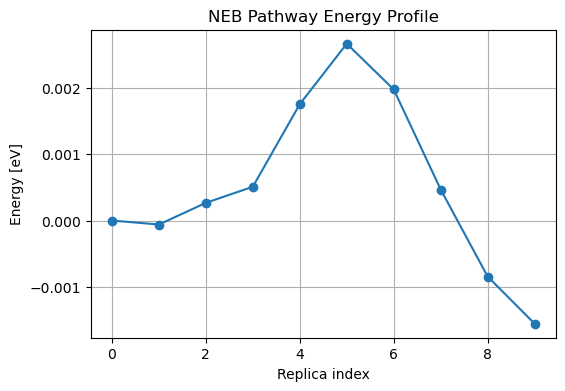

In [13]:
# Plot translational energy path
traj_path = "/projects/westgroup/lekia.p/NEB/NEB_Results/neb_translation.traj"
plot_neb_energy_path(traj_path)

In [40]:
def plot_rotation_neb(traj_file, angle_range=120):
    """
    Simple plot of energy vs rotation angle from NEB trajectory
    
    Args:
        traj_file: path to NEB trajectory file
        angle_range: total rotation angle in degrees (default 120)
    """
    from ase.io import read
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Read trajectory
    images = read(traj_file, ':')

    n_images = 10
    
    # Extract only the LAST set of images (final converged path)
    images = images[-(n_images+2):]
    
    # Get energies
    energies = np.array([img.get_potential_energy() for img in images])
    
    # Linearly interpolate rotation angles
    angles = np.linspace(0, angle_range, len(images))
    
    energies = (energies - energies.min())
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(angles, energies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Rotation Angle (degrees)', fontsize=12)
    plt.ylabel('Energy (eV)', fontsize=12)
    plt.title('Rotational Barrier', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.savefig('rotation_barrier.png', dpi=300)
    plt.show()
    
    print(f"Barrier height: {energies.max():.6f} eV")
    
    return angles, energies

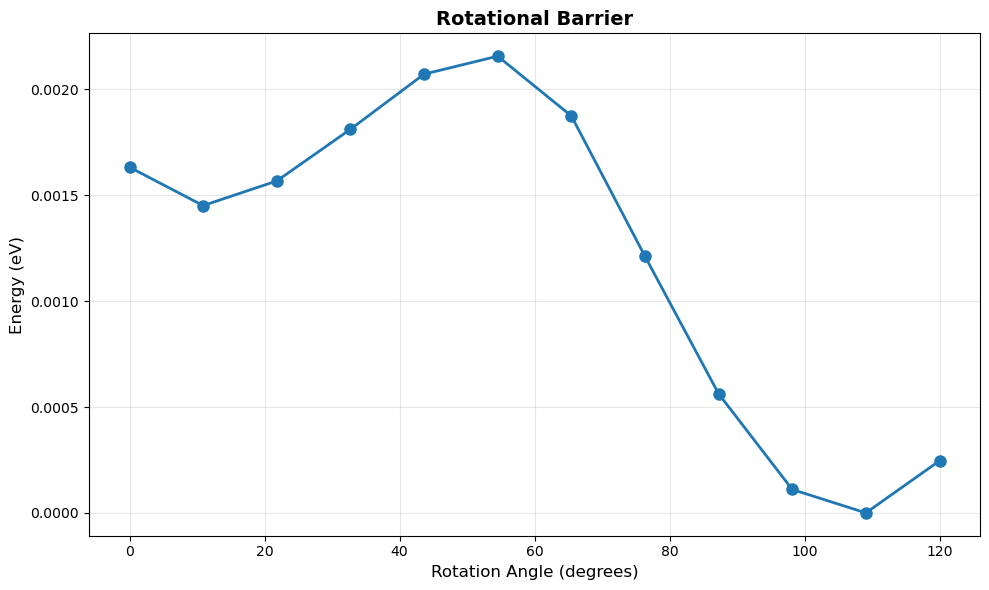

Barrier height: 0.002157 eV


In [41]:
# Plot rotational energy path
traj_path = "/projects/westgroup/lekia.p/NEB/NEB_Results/neb_rotation.traj"
# plot_neb_energy_path(traj_path)
angles, energies = plot_rotation_neb(traj_path)

In [19]:
surface_type = 'fcc111'
metal = 'Pt'
M = 54 # Number of surface sites
NA = 6.02214076e23 # mol^-1

In [ ]:
vacuum = 20
size = (3, 3, 3) # slab size
lattice_constant_vdW = 3.92
lattice_constant = 3.97 # Angstrom
b = lattice_constant_vdW

In [ ]:
W_x = 0.002711
W_y = W_x
m = 16
W_r = 0.000525
T = 300 # K
n = 3 # number of equivalent minima in one full rotation (n=1 for heteronuclear diatomic molecules, n=2 for homonuclear diatomic molecules, n=3 for NH3, etc.)
symmetric_number=3 # for CH4 on surface
rotor_asymmetric=False

In [ ]:
moi = get_moment_of_inertia_about_binding_atom(ads=ads)

In [ ]:
trans = HinderedTranslationPartitionFunction(
    m,
    W_x,
    W_y,
    b,
    M,  # number of surface sites
    T  # temperature in K
)

rotor = HinderedRotorPartitionFunction(
        W_r,  # barrier height in eV
        n,  # number of equivalent minima
        moi,  # reduced moment of inertia in amu*Angstrom^2
        T,  # temperature in K
        symmetric_number,
        rotor_asymmetric
    )

translational_partition_function = trans.q_trans()
print(translational_partition_function)

rotor_partition_function = rotor.q_rot()
print(rotor_partition_function)

10214.418750416426
2.766416533528634


In [ ]:
sitedensity = 8.79e+19

In [ ]:
# Load rotation NEB
rot_images = read('/projects/westgroup/lekia.p/NEB/NEB_Results/neb_rotation.traj', ':')
rot_energies = np.array([img.get_potential_energy() for img in rot_images])
rot_barrier_energy = rot_energies.max() - rot_energies.min()

# Load translation NEB
trans_images = read('/projects/westgroup/lekia.p/NEB/NEB_Results/neb_translation.traj', ':')
trans_energies = np.array([img.get_potential_energy() for img in trans_images])
trans_barrier_energy = trans_energies.max() - trans_energies.min()

minimum_structure = rot_images[0].copy()  # or trans_images[0] or rot_images[-1]

# Verify it's actually the minimum
min_energy_rot = min(rot_energies)
min_energy_trans = min(trans_energies)
print(f"\nMinimum energy (rotation NEB): {min_energy_rot:.6f} eV")
print(f"Minimum energy (translation NEB): {min_energy_trans:.6f} eV")
print(f"Difference: {abs(min_energy_rot - min_energy_trans):.6f} eV (should be ~0)")


Minimum energy (rotation NEB): -161.485031 eV
Minimum energy (translation NEB): -161.484835 eV
Difference: 0.000196 eV (should be ~0)


In [ ]:
vib = Vibrations(
    minimum_structure,
    indices=vibatoms,   
    name='vib',
)
vib.run()
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0    0.6       5.1
  1    1.2       9.4
  2    3.0      24.2
  3    8.3      67.2
  4    9.3      74.8
  5   10.4      83.5
  6  159.5    1286.6
  7  159.6    1287.0
  8  159.8    1288.7
  9  186.7    1506.2
 10  186.8    1506.9
 11  363.5    2932.1
 12  377.3    3042.8
 13  377.9    3048.1
 14  378.3    3051.2
---------------------
Zero-point energy: 1.191 eV


In [ ]:
vib_energies = vib.get_energies()
print(vib_energies)

[0.00062721+0.j 0.0011671 +0.j 0.00299782+0.j 0.00832684+0.j
 0.00927376+0.j 0.01035868+0.j 0.15951858+0.j 0.15957154+0.j
 0.15977416+0.j 0.18674269+0.j 0.18682624+0.j 0.36353079+0.j
 0.37725468+0.j 0.37791712+0.j 0.37830373+0.j]


In [ ]:
from ase.thermochemistry import HinderedThermo

thermo = HinderedThermo(
    vib_energies=vib_energies,
    trans_barrier_energy=W_x,
    rot_barrier_energy=W_r,
    sitedensity=sitedensity,
    rotationalminima=n,
    symmetrynumber=symmetric_number,
    mass=m,
    inertia=moi,
)

In [ ]:
thermo.get_entropy(300)

Entropy components at T = 300.00 K:
                           S               T*S
S_trans           -0.0001820 eV/K       -0.055 eV
S_rot              0.0001314 eV/K        0.039 eV
S_vib              0.0005296 eV/K        0.159 eV
S_con              0.0014508 eV/K        0.435 eV
-------------------------------------------------
S                  0.0019299 eV/K        0.579 eV


0.0019298765835227341

In [ ]:
thermo.get_helmholtz_energy(300)

Internal energy components at T = 300.00 K:
E_pot                  0.000 eV
E_trans               -0.353 eV
E_rot                  0.013 eV
E_vib                  0.066 eV
E_ZPE                  1.540 eV
-------------------------------
U                      1.265 eV

Entropy components at T = 300.00 K:
                           S               T*S
S_trans           -0.0001820 eV/K       -0.055 eV
S_rot              0.0001314 eV/K        0.039 eV
S_vib              0.0005296 eV/K        0.159 eV
S_con              0.0014508 eV/K        0.435 eV
-------------------------------------------------
S                  0.0019299 eV/K        0.579 eV

Free energy components at T = 300.00 K:
    U          1.265 eV
 -T*S         -0.579 eV
-----------------------
    F          0.686 eV


0.6857707366709241

In [ ]:
thermo.get_internal_energy(300)

Internal energy components at T = 300.00 K:
E_pot                  0.000 eV
E_trans               -0.353 eV
E_rot                  0.013 eV
E_vib                  0.066 eV
E_ZPE                  1.540 eV
-------------------------------
U                      1.265 eV


1.2647337117277444

In [ ]:
def create_janaf_table(thermo, T_range=(50, 1000, 50), reference_T=298.15, potentialenergy=None, SI_unit=True):
    if potentialenergy is None:
        potentialenergy = 0.0
    
    temperatures = np.arange(T_range[0], T_range[1] + T_range[2], T_range[2])

    NA = 6.02214076e23 # mol^-1
    EV = 1.60218e-19  # J (electron volt conversion)
    

    if SI_unit == True:
        EV_TO_J = NA * EV # J/mol
    else:
        EV_TO_J = 1
    
    if SI_unit == True:
        data = {
            'T (K)': temperatures,
            'S (J/mol/K)': [],
            'U (J/mol)': [],
            'A (J/mol)': [],
            'Cv (J/mol/K)': [],
            'G (J/mol)': [],
            'H (J/mol)': [],
            '-(G-H(Tref))/T (J/mol/K)': [],
            'H-H(Tref) (J/mol)': [],
        }
    else:
        data = {
            'T (K)': temperatures,
            'S (eV/K)': [],
            'U (eV)': [],
            'A (eV)': [],
            'Cv (eV/K)': [],
            'G (eV)': [],
            'H (eV)': [],
            '-(G-H(Tref))/T (eV/K)': [],
            'H-H(Tref) (eV)': [],
        }

    
    S_ref = thermo.get_entropy(reference_T, potentialenergy) * EV_TO_J
    U_ref = thermo.get_internal_energy(reference_T, potentialenergy) * EV_TO_J
    A_ref = thermo.get_helmholtz_energy(reference_T, potentialenergy) * EV_TO_J
    H_ref = U_ref  # For surface species, H ≈ U (constant area)
    G_ref = A_ref  # For surface species, G ≈ A (constant area)
    
    for T in temperatures:
        # Basic properties
        S = thermo.get_entropy(T, potentialenergy) * EV_TO_J
        U = thermo.get_internal_energy(T, potentialenergy) * EV_TO_J
        A = thermo.get_helmholtz_energy(T, potentialenergy) * EV_TO_J
        
        # For surface species: H ≈ U, G ≈ A (constant area approximation)
        H = U
        G = A
        
        # Heat capacity (numerical derivative)
        dT = 1.0  # K
        if T > T_range[0]:
            U_plus = thermo.get_internal_energy(T + dT, potentialenergy) * EV_TO_J
            U_minus = thermo.get_internal_energy(T - dT, potentialenergy) * EV_TO_J
            Cv = (U_plus - U_minus) / (2 * dT)
        else:
            U_plus = thermo.get_internal_energy(T + dT, potentialenergy) * EV_TO_J
            Cv = (U_plus - U) / dT
        
        # JANAF-style derived properties
        gibbs_function = -(G - H_ref) / T if T > 0 else 0
        enthalpy_diff = H - H_ref
        
        # Store values
        if SI_unit == True:
            data['S (J/mol/K)'].append(S)
            data['U (J/mol)'].append(U)
            data['A (J/mol)'].append(A)
            data['Cv (J/mol/K)'].append(Cv)
            data['G (J/mol)'].append(G)
            data['H (J/mol)'].append(H)
            data['-(G-H(Tref))/T (J/mol/K)'].append(gibbs_function)
            data['H-H(Tref) (J/mol)'].append(enthalpy_diff)
        else:
            data['S (eV/K)'].append(S)
            data['U (eV)'].append(U)
            data['A (eV)'].append(A)
            data['Cv (eV/K)'].append(Cv)
            data['G (eV)'].append(G)
            data['H (eV)'].append(H)
            data['-(G-H(Tref))/T (eV/K)'].append(gibbs_function)
            data['H-H(Tref) (eV)'].append(enthalpy_diff)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df

In [ ]:
table = create_janaf_table(thermo)
table

,T (K),S (J/mol/K),U (J/mol),A (J/mol),Cv (J/mol/K),G (J/mol),H (J/mol),-(G-H(Tref))/T (J/mol/K),H-H(Tref) (J/mol)
0,50,142.406159,117048.735096,109928.427125,13.859728,109928.427125,117048.735096,241.145841,-4936.984091
1,100,157.769481,117893.650156,102116.702030,18.679427,102116.702030,117893.650156,198.690172,-4092.069031
2,150,167.850963,118861.615390,93683.970950,19.834383,93683.970950,118861.615390,188.678322,-3124.103797
3,200,175.238452,119869.184014,84821.493665,20.475312,84821.493665,119869.184014,185.821128,-2116.535173
4,250,181.140438,120915.419301,75630.309753,21.476056,75630.309753,120915.419301,185.421638,-1070.299886
5,300,186.205174,122028.508592,66166.956297,23.167065,66166.956297,122028.508592,186.062543,42.789405
6,350,190.799167,123242.958145,56463.249608,25.503608,56463.249608,123242.958145,187.207056,1257.238957
7,400,195.122840,124586.331568,46537.195386,28.288771,46537.195386,124586.331568,188.621310,2600.612381
8,450,199.281602,126076.109614,36399.388798,31.332669,36399.388798,126076.109614,190.191845,4090.390427
9,500,203.330266,127721.691381,26056.558204,34.503991,26056.558204,127721.691381,191.858322,5735.972194


In [ ]:
def plot_thermochemistry(df, filename=None):
    """
    Create plots of thermochemical properties vs temperature.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Entropy
    axes[0, 0].plot(df['T (K)'], df['S (eV/K)'] * 1000, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Temperature (K)', fontsize=12)
    axes[0, 0].set_ylabel('Entropy (meV/K)', fontsize=12)
    axes[0, 0].set_title('Entropy vs Temperature', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Heat Capacity
    axes[0, 1].plot(df['T (K)'], df['Cv (eV/K)'] * 1000, 'r-', linewidth=2)
    axes[0, 1].set_xlabel('Temperature (K)', fontsize=12)
    axes[0, 1].set_ylabel('Heat Capacity Cv (meV/K)', fontsize=12)
    axes[0, 1].set_title('Heat Capacity vs Temperature', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Free Energies
    axes[1, 0].plot(df['T (K)'], df['G (eV)'], 'g-', linewidth=2, label='G (Gibbs)')
    axes[1, 0].plot(df['T (K)'], df['U (eV)'], 'orange', linewidth=2, label='U (Internal)')
    axes[1, 0].set_xlabel('Temperature (K)', fontsize=12)
    axes[1, 0].set_ylabel('Energy (eV)', fontsize=12)
    axes[1, 0].set_title('Thermodynamic Functions vs Temperature', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Gibbs Function
    axes[1, 1].plot(df['T (K)'], df['-(G-H(Tref))/T (eV/K)'] * 1000, 'm-', linewidth=2)
    axes[1, 1].set_xlabel('Temperature (K)', fontsize=12)
    axes[1, 1].set_ylabel('-(G-H(Tref))/T (meV/K)', fontsize=12)
    axes[1, 1].set_title('Gibbs Function vs Temperature', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plots saved to {filename}")
    
    plt.show()

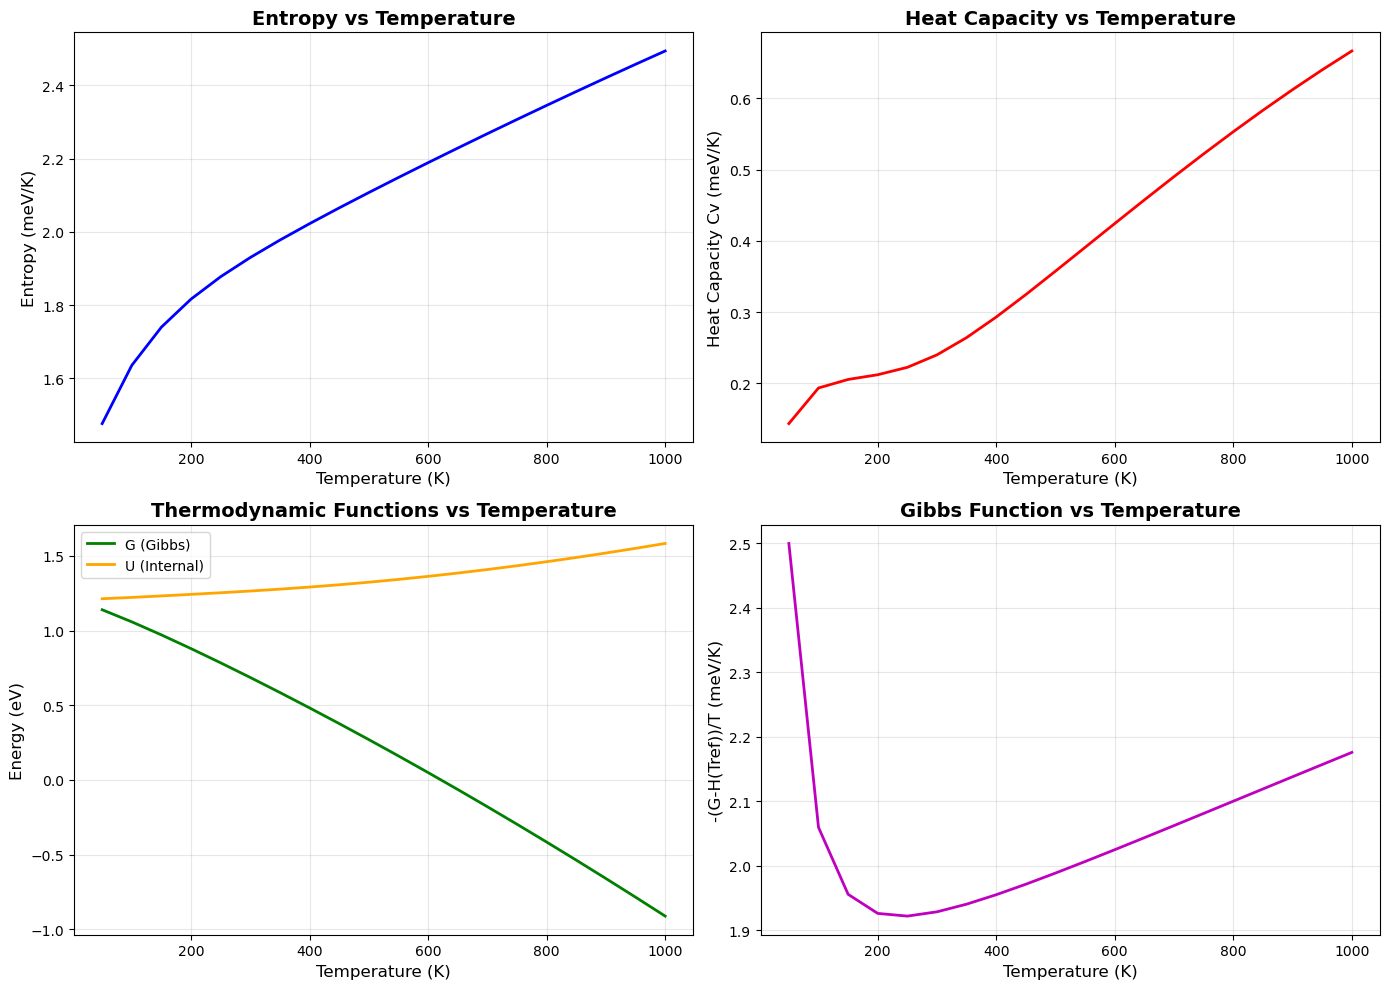

In [ ]:
plot_thermochemistry(table, filename=None)